In [1]:
import numpy as np
from numpy import linalg as la
from numpy import *
import matplotlib.pyplot as plt
from matplotlib import cm
from tqdm import tqdm
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split


print (torch.__version__, torch.cuda.is_available())
print(torch.version.cuda)
print (torch.cuda.get_device_name())


# device= 'cpu'
device= 'cuda'

2.3.1 True
11.8
NVIDIA GeForce RTX 3070 Ti


OU process(1D):
$$dX_t = \theta(\mu-X_t)dt + \sigma dW_t$$

In [2]:
def ou_process_1d(theta=1, mu=0, sigma=1, X0=0, n_steps=10000, n_eval=200, h=1e-5):
    """
    Simulates the Ornstein-Uhlenbeck process.
    
    Parameters:
    - theta: rate of mean reversion
    - mu: long-term mean of the process
    - sigma: volatility
    - X0: initial value
    - n_steps: number of steps in each evaluation
    - n_eval: number of evaluations
    - h: Integration step size
    
    Returns:
    - A numpy array containing the simulated values at each evaluation
    """
    X_eval = np.zeros(n_eval)
    X = X0
    
    for i in range(n_eval):
        for _ in range(n_steps):
            dW = np.sqrt(h) * np.random.randn()
            X = X + theta * (mu - X) * h + sigma * dW
        X_eval[i] = X
    
    return X_eval

In [3]:
## Setup the parameters
theta = 1
mu = 0
sigma = 0.1

In [4]:
# ## Simulate a single trajectory
# n_steps = 10000
# h = 1e-5
# n_eval = 200
# lag_time = n_steps * h

# X0 = np.random.uniform(-2, 2) # initial point
# X_eval = ou_process_1d(X0=X0, n_steps=n_steps, n_eval=n_eval, h=h)
# print(X_eval.shape)
# # Plot the simulated path

# times = np.linspace(0, n_eval, len(X_eval)) # Creating the time array for plotting

# plt.figure(figsize=(8, 4))
# plt.plot(times, X_eval, label=f"1D OU Process: theta={theta}, mu={mu}, sigma={sigma}")
# plt.title("Simulation of the 1D OU Process")
# plt.xlabel("Time")
# plt.ylabel("Xt")
# plt.legend()
# plt.grid(True)
# plt.show()

In [5]:
# Generate m initial points from the domain space [-2, 2]
m = 20
n_eval = 100
n_steps = 1000
h = 1e-4
lag_time = n_steps * h
X0_values = np.linspace(-2, 2, m)

# Initialize the data_matrix
data_matrix = np.zeros((m, n_eval+1, 1))

# Simulate trajectories for each initial point and store them in the data_matrix
for i, X0 in tqdm(enumerate(X0_values), total=m, desc="Simulating trajectories"):
    X_eval = np.concatenate(([X0], ou_process_1d(X0=X0, n_steps=n_steps, n_eval=n_eval, h=h)))
    data_matrix[i, :, 0] = X_eval

# Print the shape of data_matrix
print("Shape of data_matrix:", data_matrix.shape)

Simulating trajectories: 100%|██████████| 20/20 [00:02<00:00,  7.28it/s]

Shape of data_matrix: (20, 101, 1)


In [6]:
# ## Save the data to local folder
# # Create a folder to store the data (if it doesn't exist)
# folder_path = "data"
# os.makedirs(folder_path, exist_ok=True)

# # Save the data_matrix to a file
# file_path = os.path.join(folder_path, "ou_process_1d.npy")
# np.save(file_path, data_matrix)

In [7]:
# ## load the data from local folder
# # Load the data_matrix from the file
# folder_path = "data"
# file_path = os.path.join(folder_path, "ou_process_1d.npy")
# data_matrix = np.load(file_path)

In [8]:
# Extract data_X and data_Y from the data matrix
data_X = data_matrix[:, :-1, :]
data_Y = data_matrix[:, 1:, :]
print(f"Shape of data_X: {data_X.shape}")
print(f"Shape of data_Y: {data_Y.shape}")

# Reshape data_X and data_Y into a single column
X = data_X.reshape(-1, data_X.shape[2])  # 2D features
Y = data_Y.reshape(-1, data_X.shape[2])  # 2D targets
print(f"Shape of X: {X.shape}")
print(f"Shape of Y: {Y.shape}")

Shape of data_X: (20, 100, 1)
Shape of data_Y: (20, 100, 1)
Shape of X: (2000, 1)
Shape of Y: (2000, 1)


In [9]:
# Separate data into two parts: train and validation
len_all = X.shape[0]
data_x_train = X[:int(0.7*len_all)]
data_x_valid = X[int(0.7*len_all)+1:]

data_y_train = Y[:int(0.7*len_all)]
data_y_valid = Y[int(0.7*len_all)+1:]

data_train = [data_x_train, data_y_train]
data_valid = [data_x_valid, data_y_valid]

print(data_x_train.shape)

(1400, 1)


In [23]:
checkpoint_file= 'ou1d_example_ckpt002.torch'

from solver_edmd_torch_gpu_sde import KoopmanNNTorch, KoopmanSolverTorch

basis_function = KoopmanNNTorch(input_size=1, layer_sizes=[20, 20], n_psi_train=18).to(device)

solver = KoopmanSolverTorch(dic=basis_function, # Replace 'koopman_nn' by 'dic' if you use the original solver_edmdvar
                       target_dim=np.shape(data_x_train)[-1],
                       reg=0.1,  checkpoint_file= checkpoint_file, fnn_checkpoint_file= 'example_fnn_ou_001.torch', 
                generator_batch_size= 4, fnn_batch_size= 32, delta_t= lag_time)

data_x_train_tensor = torch.DoubleTensor(data_x_train).to (device)#, requieres_grad= True)#, dtype=tf.float64)
data_y_train_tensor = torch.DoubleTensor(data_y_train).to (device)#, requires_grad= True)#, dtype=tf.float64)

In [24]:
# # Compute the drift and diffusion terms
# #b_Xt, a_Xt = solver.compute_var_coefficients(data_x_train_tensor)
# b_Xt, a_Xt = solver.compute_neural_a_b(data_x_train_tensor)
# print("\nDrift term (b_Xt):")
# print(b_Xt.detach().shape)
# print(b_Xt.detach().cpu().numpy())
# print("\nDiffusion term (a_Xt):")
# print(a_Xt.shape)
# print(a_Xt.detach().cpu().numpy())

In [25]:
# # Compute L_Psi
# L_Psi = solver.compute_generator_L(data_x_train_tensor, b_Xt, a_Xt)

# print("\nL_Psi:")
# print(L_Psi.shape)
# print(L_Psi.detach().cpu().numpy())

In [26]:
solver.build_with_generator(
    data_train=data_train,
    data_valid=data_valid,
    epochs=6,
    batch_size=256,
    lr=1e-5,
    log_interval=10,
    lr_decay_factor=.8
    )

Epoch: 1 	Training Loss: 1.237731 val loss: 1.227446
saving, val loss enhanced: 1.227445875045752 10000
Epoch: 2 	Training Loss: 1.206675 val loss: 1.209258
saving, val loss enhanced: 1.2092581384831398 1.227445875045752
Epoch: 3 	Training Loss: 1.192748 val loss: 1.183118
saving, val loss enhanced: 1.1831176834413735 1.2092581384831398
Epoch: 4 	Training Loss: 1.182728 val loss: 1.175695
saving, val loss enhanced: 1.1756951067323205 1.1831176834413735
Epoch: 5 	Training Loss: 1.166120 val loss: 1.151482
saving, val loss enhanced: 1.1514819211851433 1.1756951067323205
Epoch: 6 	Training Loss: 1.148768 val loss: 1.135000
saving, val loss enhanced: 1.1349997881409464 1.1514819211851433
Epoch: 7 	Training Loss: 1.132231 val loss: 1.125915
saving, val loss enhanced: 1.1259153320942574 1.1349997881409464
Epoch: 8 	Training Loss: 1.110967 val loss: 1.103416
saving, val loss enhanced: 1.1034155610941605 1.1259153320942574
Epoch: 9 	Training Loss: 1.104476 val loss: 1.076637
saving, val loss e

Computing dPsi_X: 100%|██████████| 27980/27980 [00:06<00:00, 4060.06iteration/s]


dPsi_X shape:  torch.Size([1399, 20])
psi_x shape:  torch.Size([1399, 20])
psi_x_inv shape:  torch.Size([20, 1399])
cuda:0
cuda:0
Outer Epoch 1/6


Computing dPsi_X: 100%|██████████| 27980/27980 [00:07<00:00, 3910.20iteration/s]


dPsi_X shape:  torch.Size([1399, 20])
psi_x shape:  torch.Size([1399, 20])
psi_x_inv shape:  torch.Size([20, 1399])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 22620.247222 val loss: 24125.727092
saving, val loss enhanced: 24125.727091726698 1000000000000000.0
Epoch: 2 	Training Loss: 22474.309899 val loss: 23973.974927
saving, val loss enhanced: 23973.97492709796 24125.727091726698
Epoch: 3 	Training Loss: 22329.366607 val loss: 23822.512904
saving, val loss enhanced: 23822.51290417146 23973.97492709796
Epoch: 4 	Training Loss: 22185.071705 val loss: 23671.629471
saving, val loss enhanced: 23671.629471080283 23822.51290417146
Epoch 1 time: 20.61 seconds
Outer Epoch 2/6


Computing dPsi_X: 100%|██████████| 27980/27980 [00:07<00:00, 3726.14iteration/s]


dPsi_X shape:  torch.Size([1399, 20])
psi_x shape:  torch.Size([1399, 20])
psi_x_inv shape:  torch.Size([20, 1399])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 24054.708407 val loss: 25680.223546
Epoch: 2 	Training Loss: 23893.830623 val loss: 25510.504046
Epoch: 3 	Training Loss: 23732.066264 val loss: 25340.801301
Epoch: 4 	Training Loss: 23570.709189 val loss: 25171.932677
Epoch 2 time: 20.68 seconds
Outer Epoch 3/6


Computing dPsi_X: 100%|██████████| 27980/27980 [00:07<00:00, 3966.36iteration/s]


dPsi_X shape:  torch.Size([1399, 20])
psi_x shape:  torch.Size([1399, 20])
psi_x_inv shape:  torch.Size([20, 1399])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 25587.080308 val loss: 27342.898110
Epoch: 2 	Training Loss: 25406.146209 val loss: 27151.536711
Epoch: 3 	Training Loss: 25223.920933 val loss: 26960.168486
Epoch: 4 	Training Loss: 25042.245516 val loss: 26769.986084
Epoch 3 time: 21.36 seconds
Outer Epoch 4/6


Computing dPsi_X: 100%|██████████| 27980/27980 [00:07<00:00, 3944.28iteration/s]


dPsi_X shape:  torch.Size([1399, 20])
psi_x shape:  torch.Size([1399, 20])
psi_x_inv shape:  torch.Size([20, 1399])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 26937.024034 val loss: 28817.040248
Epoch: 2 	Training Loss: 26735.651678 val loss: 28604.009747
Epoch: 3 	Training Loss: 26533.177089 val loss: 28391.292895
Epoch: 4 	Training Loss: 26331.618954 val loss: 28180.206660
Epoch 4 time: 20.09 seconds
Outer Epoch 5/6


Computing dPsi_X: 100%|██████████| 27980/27980 [00:06<00:00, 4001.45iteration/s]


dPsi_X shape:  torch.Size([1399, 20])
psi_x shape:  torch.Size([1399, 20])
psi_x_inv shape:  torch.Size([20, 1399])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 28206.789448 val loss: 30213.003665
Epoch: 2 	Training Loss: 27984.037720 val loss: 29977.072591
Epoch: 3 	Training Loss: 27760.207169 val loss: 29741.660802
Epoch: 4 	Training Loss: 27537.577579 val loss: 29508.269291
Epoch 5 time: 23.52 seconds
Outer Epoch 6/6


Computing dPsi_X: 100%|██████████| 27980/27980 [00:06<00:00, 4045.53iteration/s]


dPsi_X shape:  torch.Size([1399, 20])
psi_x shape:  torch.Size([1399, 20])
psi_x_inv shape:  torch.Size([20, 1399])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 29354.460347 val loss: 31485.394608
Epoch: 2 	Training Loss: 29110.086475 val loss: 31226.308164
Epoch: 3 	Training Loss: 28864.834755 val loss: 30968.059214
Epoch: 4 	Training Loss: 28621.144042 val loss: 30712.263974
Epoch 6 time: 19.44 seconds


In [27]:
# Results from solver_edmd/solver_resdmd
evalues = solver.eigenvalues.T
efuns = solver.eigenfunctions(X)
# kpm_modes = solver.compute_mode().T
N_dict = np.shape(evalues)[0]
# Psi_X = solver.get_Psi_X()
# Psi_Y = solver.get_Psi_Y()
Koopman_matrix_K = solver.K
# Psi_X2, Psi_Y2 = solver.get_basis(data_x_train, data_y_train)
# Psi_X2 = Psi_X2.numpy()
# Psi_Y2 = Psi_Y2.numpy()
# jacobian, hessian = solver.get_derivatives(data_x_valid) # Currently the storage is not enough to calculate for larger amount of data
# np_config.enable_numpy_behavior()
outputs = {
    'efuns': efuns,
    'evalues': evalues,
    # 'kpm_modes': kpm_modes,
    'N_dict': N_dict,
    'K': Koopman_matrix_K,
    # 'Psi_X': Psi_X,
    # 'Psi_Y': Psi_Y,
    # 'Psi_X2': Psi_X2,
    # 'Psi_Y2': Psi_Y2,
    # "Jacobian": jacobian,  # Uncomment if needed
    # "Hessian": hessian,    # Uncomment if needed
    }

In [28]:
print(evalues.shape)
print(evalues[:4])

(20,)
[0.99999767+0.j 0.91275971+0.j 0.78599511+0.j 0.69230754+0.j]


In [29]:
# Take ln values of the eigenvalues and divide by 0.1
ln_evalues = np.log(evalues[:4]) / lag_time

print(ln_evalues)

[-2.33366094e-05+0.j -9.12826253e-01+0.j -2.40804710e+00+0.j
 -3.67724998e+00+0.j]


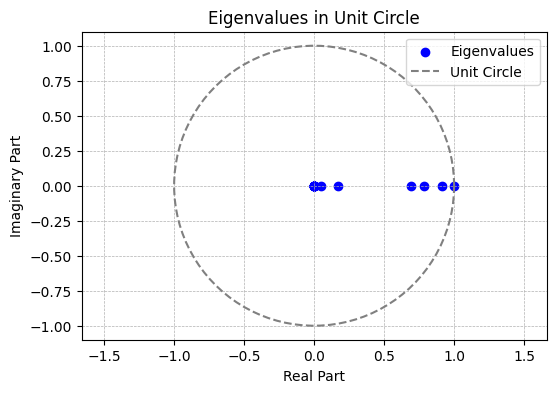

In [30]:
## Plot eigenvalues on unit circle
# Assuming evalues is a numpy array of complex numbers
real_parts = evalues.real
imag_parts = evalues.imag

# Create the plot
plt.figure(figsize=(6, 4))
plt.scatter(real_parts, imag_parts, color='blue', label='Eigenvalues')

# Draw a unit circle for reference
theta = np.linspace(0, 2*np.pi, 100)
plt.plot(np.cos(theta), np.sin(theta), linestyle='--', color='grey', label='Unit Circle')

plt.title('Eigenvalues in Unit Circle')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.axis('equal')  # Ensure the aspect ratio is equal to make the unit circle round
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

In [31]:
efuns_real = np.real(efuns)
print(efuns_real.shape)
print(efuns_real)

(2000, 20)
[[ 1.23136533e+00  8.86839599e-01 -1.09466494e-01 ... -1.32995930e-09
  -8.14245141e-06  6.60630697e-05]
 [ 1.23139876e+00  8.81527237e-01 -1.07328199e-01 ... -3.57739060e-09
  -8.09476824e-06  6.79955538e-05]
 [ 1.23127729e+00  9.28136126e-01 -1.27776142e-01 ...  2.61953474e-08
  -1.92768255e-06 -5.94767413e-06]
 ...
 [ 1.23280498e+00 -1.80482003e-01  1.83653155e-02 ...  4.60720766e-10
  -1.62686577e-08 -8.34464710e-06]
 [ 1.23284222e+00 -2.27580266e-01  1.59278684e-02 ...  1.71533512e-09
  -1.12086084e-07 -7.05720178e-06]
 [ 1.23279151e+00 -1.43552120e-01  1.98671824e-02 ... -4.92172905e-10
   6.66244821e-08 -8.56598777e-06]]


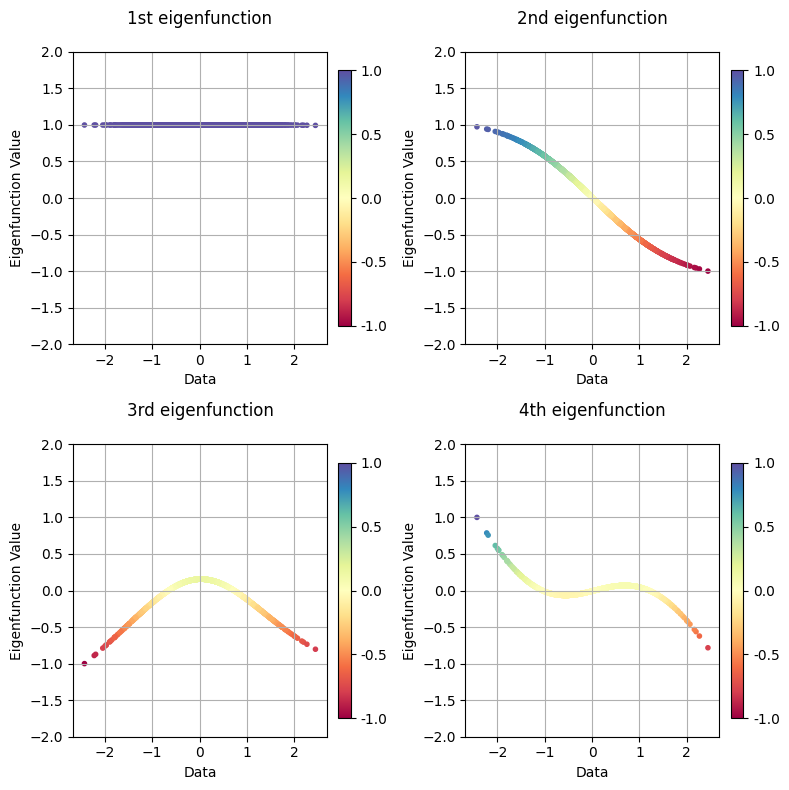

In [32]:
## Plot eigenfunctions
# Get the real part of eigenfunctions and normalize them
phi = np.real(efuns)

# Use the entire efuns instead of slicing
for i in range(len(evalues)):
    phi[:, i] = phi[:, i] / np.max(np.abs(phi[:, i]))

# Create a plot with 2x2 layout
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
titles = ['1st eigenfunction', '2nd eigenfunction', '3rd eigenfunction', '4th eigenfunction']

# Determine global min and max values for the eigenfunctions for a uniform scale
vmin = np.min(phi)
vmax = np.max(phi)
cbar_ticks = np.linspace(vmin, vmax, 5)

# Flatten the 2D array of axes for easy iteration
axs_flat = axs.flatten()

for i, (ax, title) in enumerate(zip(axs_flat, titles)):
    scatter = ax.scatter(X, phi[:, i], c=phi[:, i], cmap='Spectral', marker='.', vmin=vmin, vmax=vmax)
    ax.set_title(title, pad=20)
    ax.set_xlabel('Data')
    ax.set_ylabel('Eigenfunction Value')
    ax.set_ylim(-2, 2)
    cbar = fig.colorbar(scatter, ax=ax, orientation='vertical', fraction=0.046, pad=0.04, ticks=cbar_ticks)
    cbar.set_ticklabels([f"{tick:.1f}" for tick in cbar_ticks])
    ax.grid()

plt.tight_layout()
plt.show()

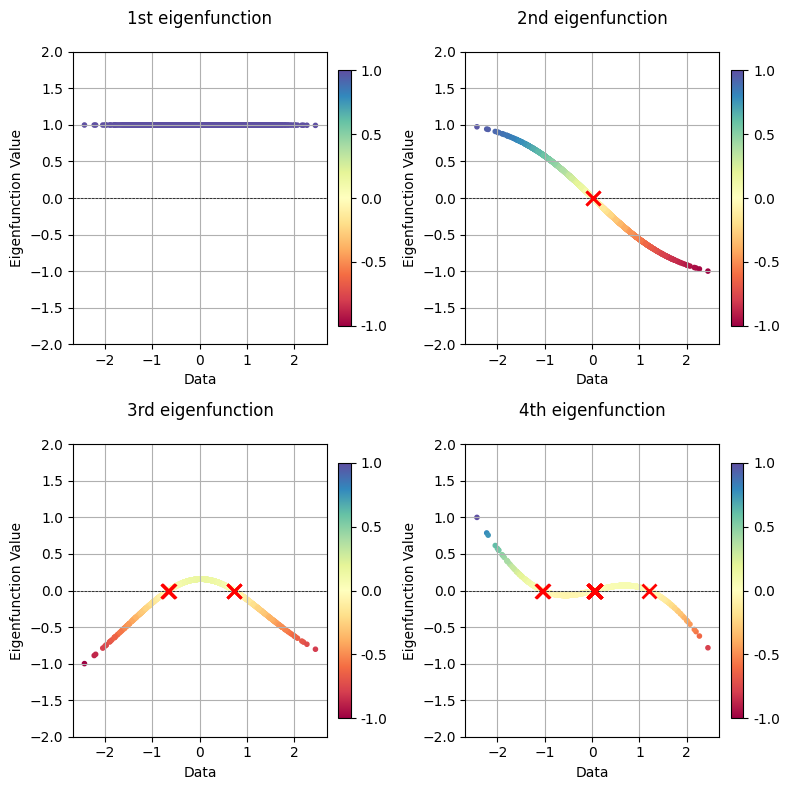

In [33]:
## Plot eigenfunctions with red cross at zero points
# Get the real part of eigenfunctions and normalize them
phi = np.real(efuns)

# Use the entire efuns instead of slicing
for i in range(len(evalues)):
    phi[:, i] = phi[:, i] / np.max(np.abs(phi[:, i]))

# Create a plot with 2x2 layout
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
titles = ['1st eigenfunction', '2nd eigenfunction', '3rd eigenfunction', '4th eigenfunction']

# Determine global min and max values for the eigenfunctions for a uniform scale
vmin = np.min(phi)
vmax = np.max(phi)
cbar_ticks = np.linspace(vmin, vmax, 5)

# Flatten the 2D array of axes for easy iteration
axs_flat = axs.flatten()

for i, (ax, title) in enumerate(zip(axs_flat, titles)):
    scatter = ax.scatter(X, phi[:, i], c=phi[:, i], cmap='Spectral', marker='.', vmin=vmin, vmax=vmax)
    ax.set_title(title, pad=20)
    ax.set_xlabel('Data')
    ax.set_ylabel('Eigenfunction Value')
    ax.set_ylim(-2, 2)
    
    # Add x-axis
    ax.axhline(y=0, color='black', linestyle='--', linewidth=0.5)

    # Find points where the function crosses the x-axis, add tolerance value
    tolerance = 1e-3
    zero_crossings = np.where(np.abs(phi[:, i]) < tolerance)[0]

    # Reduce the number of markers
    max_markers = 10
    if len(zero_crossings) > max_markers:
        zero_crossings = zero_crossings[::len(zero_crossings)//max_markers]

    # Add red markers at crossing points
    for crossing in zero_crossings:
        ax.plot(X[crossing], 0, 'rx', markersize=10, markeredgewidth=2)

    cbar = fig.colorbar(scatter, ax=ax, orientation='vertical', fraction=0.046, pad=0.04, ticks=cbar_ticks)
    cbar.set_ticklabels([f"{tick:.1f}" for tick in cbar_ticks])
    ax.grid()

plt.tight_layout()
plt.show()

In [34]:
# # Get the real part of eigenfunctions and normalize them
# phi_train = np.real(efuns[:int(0.7*len_all), :])  # Slice efuns to match data_x_train
# for i in range(len(evalues)):
#     phi_train[:, i] = phi_train[:, i] / np.max(np.abs(phi_train[:, i]))

# # Create a plot
# fig, axs = plt.subplots(6, 1, figsize=(6, 30))
# titles = ['1st eigenfunction', '2nd eigenfunction', '3rd eigenfunction', '4th eigenfunction', '5th eigenfunction',
#           '6th eigenfunction']

# # Determine global min and max values for the eigenfunctions for a uniform scale
# vmin = np.min(phi_train)
# vmax = np.max(phi_train)
# cbar_ticks = np.linspace(vmin, vmax, 5)

# for i, title in enumerate(titles):
#     ax = axs[i]
#     scatter = ax.scatter(data_x_train, phi_train[:, i], c=phi_train[:, i], cmap='Spectral', marker='.', vmin=vmin, vmax=vmax)
#     ax.set_title(title, pad=20)
#     ax.set_xlabel('Data')
#     ax.set_ylabel('Eigenfunction Value')
#     ax.set_ylim(-2, 2)
#     cbar = fig.colorbar(scatter, ax=ax, orientation='vertical', fraction=0.05, ticks=cbar_ticks)
#     cbar.set_ticklabels([f"{tick:.1f}" for tick in cbar_ticks])

# plt.tight_layout()
# plt.show()